# Interactive AMM Training

This Notebook provides an interactive training session for the AMM model, allowing you to train the model on your own dataset.

In [1]:
import json
import os

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from maskterial.modeling.common.fcresnet import FCResNet
from maskterial.utils.data_loader import ContrastDataloader
from maskterial.modeling.common.distributions import ImprovedMultivariateNormal

In [2]:
def plot_data(
    X: np.ndarray,
    y: np.ndarray,
) -> None:
    """
    Plots the training data.

    Args:
        X (np.ndarray): The input data with shape (n_samples, n_classes).
        y (np.ndarray): The target labels with shape (n_samples,).

    Returns:
        None
    """

    AXIS_NAMES = [
        "Normalized Blue Contrast",
        "Normalized Green Contrast",
        "Normalized Red Contrast",
    ]

    # Unique categories in y_train
    class_ids = np.unique(y)
    colors = plt.cm.plasma(np.linspace(0, 1, len(class_ids)))

    # Assuming X_train has the shape (BS, 3)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots in a column
    # set the font size of the figure
    plt.rcParams.update({"font.size": 12})
    plt.rcParams.update({"axes.titlesize": 12})

    for i, ax in enumerate(axs):
        for class_id, color in zip(class_ids, colors):
            ax.scatter(
                X[y == class_id, i],
                X[y == class_id, (i + 1) % 3],
                color=color,
                label=f"Class {class_id}",
                s=15,
                alpha=0.1,
                ec=None,
            )

        ax.set_xlabel(AXIS_NAMES[i])
        ax.set_ylabel(AXIS_NAMES[(i + 1) % 3])
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        # the legend should not be transparent
        leg = ax.legend()
        for lh in leg.legend_handles:
            lh.set_alpha(1)
            lh.set_sizes([40])

    fig.suptitle(f"Extracted Training Data ({X.shape[0]} points)")
    plt.tight_layout()
    plt.show()


def plot_distribution(
    model: FCResNet,
    X: np.ndarray,
    y: np.ndarray,
    standard_deviation_levels: list = [1, 2, 3, 4, 5, 6],
) -> None:
    """
    Plots the approximated contrast distribution with training data.

    Args:
        model (FCResNet): The model used to compute the embeddings.
        X (np.ndarray): The input data with shape (n_samples, n_classes).
        y (np.ndarray): The target labels with shape (n_samples,).
        standard_deviation_levels (list, optional): The levels of standard deviation to plot. Defaults to [1, 2, 3, 4, 5, 6].
    """

    AXIS_NAMES = [
        "Normalized Blue Contrast",
        "Normalized Green Contrast",
        "Normalized Red Contrast",
    ]

    # Unique categories in y_train
    class_ids = np.unique(y)
    plot_colors = plt.cm.plasma(np.linspace(0, 1, len(class_ids)))

    # set the model to evaluation mode and compute the embeddings for the input data
    model.eval()
    with torch.no_grad():
        X_torch = torch.tensor(X).float()
        input_embeddings = model.get_embedding(X_torch)

    # now we compute the mean and covariance of the embeddings for each class
    # these should be distributed as a multivariate Gaussian
    loc = torch.stack(
        [torch.mean(input_embeddings[y == c], dim=0) for c in np.unique(y)]
    )
    cov = torch.stack([torch.cov(input_embeddings[y == c].T) for c in np.unique(y)])

    # normalize the covariance matrix to avoid numerical issues
    reg_cov = cov + 1e-5 * torch.eye(cov.shape[-1])

    # initialize the Gaussian Mixture Model with the computed mean and covariance
    gmm = ImprovedMultivariateNormal(loc=loc, cov=reg_cov)

    # next step is to compute the Mahalanobis distance for each point in the input space
    # we will use a 3D grid to visualize the distance which we can later plot
    X_sidelength = torch.arange(-3, 3, 0.05)
    X_cube = torch.stack(
        torch.meshgrid(X_sidelength, X_sidelength, X_sidelength, indexing="ij"),
        dim=-1,
    )
    X_cube_shape = X_cube.shape

    # X_cube flat is a 2D tensor with shape (X_sidelength^3, 3)
    # it contains all possible combinations of the 3D grid i.e. all possible contrast values between -3 and 3
    X_cube_flat = X_cube.reshape(-1, 3).float()

    # we now compute the embeddings for all possible contrast values
    with torch.no_grad():
        X_cube_embeddings = model.get_embedding(X_cube_flat)

    # X_cube_embeddings has the shape (X_sidelength^3, embedding_dim)
    # now we compute the mahalanobis distance for each point in the input space
    # this gives us a 2D tensor with shape (X_sidelength^3, num_classes)
    # each row contains the distances to all classes
    X_cube_mh_distances = gmm.mh_distance(X_cube_embeddings[:, None, :])

    # we now retrieve the smallest distance and the corresponding class for each point in the input space
    X_cube_label_distances, X_cube_labels = torch.min(X_cube_mh_distances, dim=-1)

    # now we just reshape it back to the 3D grid with shape (X_sidelength, X_sidelength, X_sidelength)
    # each point now has the smallest distance to the closest class
    X_cube_label_distances = X_cube_label_distances.cpu().numpy()
    X_cube_label_distances = X_cube_label_distances.reshape(X_cube_shape[:-1])

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
    plt.rcParams.update({"font.size": 12})
    plt.rcParams.update({"axes.titlesize": 12})

    for i, ax in enumerate(axs):
        # just quickly display the input data as a scatter plot
        for class_id, color in zip(class_ids, plot_colors):
            ax.scatter(
                X[y == class_id, i],
                X[y == class_id, (i + 1) % 3],
                color=color,
                label=f"Class {class_id}",
                s=15,
                alpha=0.1,
                ec=None,
            )

        # We now project the 3D distance onto the 2D plane of the X_cube
        # as the distances are actually 3D this works as a good approximation for the 2D case
        if i == 2:
            distance_min = X_cube_label_distances.min(axis=((i + 2) % 3))
        else:
            distance_min = X_cube_label_distances.min(axis=((i + 2) % 3)).T

        # draw the contour plot for the mahalanobis distance with the given levels
        # we draw the projection of the 3D distance onto the 2D plane of the X_cube
        ax.contour(
            X_sidelength,
            X_sidelength,
            distance_min,
            alpha=0.5,
            levels=standard_deviation_levels,
            cmap="viridis",
        )

        ax.set_xlabel(AXIS_NAMES[i])
        ax.set_ylabel(AXIS_NAMES[(i + 1) % 3])
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)

        # make the legend look nice
        leg = ax.legend()
        for lh in leg.legend_handles:
            lh.set_alpha(1)
            lh.set_sizes([40])

    fig.suptitle(
        f"Approximated Contrast Distribution with training data ({X.shape[0]} points)"
    )
    plt.tight_layout()
    plt.show()

In [3]:
## General Params
SAVE_DIR = "./data/models/AMM/Custom"
TRAIN_IMAGE_DIR = "./data/datasets/GrapheneH/train_images"
TRAIN_ANNOTATION_PATH = "./data/datasets/GrapheneH/train_semantic_masks"
TEST_IMAGE_DIR = None
TEST_ANNOTATION_PATH = None

## Training Params
NUM_ITER = 5000
LR = 0.01
LOSS_FUNCTION = nn.CrossEntropyLoss()
TEST_INTERVAL = 10
BS = 10000

## DATA PARAMS
MAX_SAMPLES_PER_CLASS = 30000
LOADED_TEST_SAMPLES = 50000
UNIFORM_CLASS_SAMPLING = True
USE_NORMALIZATION = True
USE_DBSCAN = True
DBSCAN_EPS = 0.15
USE_NEAREST_NEIGHBORS = True
NEIGHBORS = 25

## MODEL ARCHITECTURE
NUM_CLASSES = 2
INPUT_DIM = 3
EMBEDDING_DIM = 16
DEPTH = 4
SPEC_COEFF = 0.5
N_POWER_ITERATIONS = 5
SPECTRAL_NORMALIZATION = True
DROPOUT_RATE = 0.1

In [4]:
np.random.seed(42)
torch.manual_seed(42)

dataloader = ContrastDataloader(
    train_image_dir=TRAIN_IMAGE_DIR,
    train_annotation_path=TRAIN_ANNOTATION_PATH,
    test_image_dir=TEST_IMAGE_DIR,
    test_annotation_path=TEST_ANNOTATION_PATH,
    max_samples_per_class=MAX_SAMPLES_PER_CLASS,
    loaded_test_samples=LOADED_TEST_SAMPLES,
    uniform_class_sampling=UNIFORM_CLASS_SAMPLING,
    use_normalization=USE_NORMALIZATION,
    use_DBSCAN=USE_DBSCAN,
    DBSCAN_eps=DBSCAN_EPS,
    use_Nearest_Neighbors=USE_NEAREST_NEIGHBORS,
    neighbors=NEIGHBORS,
    verbose=True,
)

# we automatically set the number of classes in the model architecture based on the dataset
NUM_CLASSES = dataloader.num_classes

if TEST_ANNOTATION_PATH is not None:
    X_test, y_test = dataloader.get_test_data()
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)

Processing Image   438/  438 (100.0%)
Loaded 438 images from masks
Applying Nearest Neighbors (Denoising Classes)
Applying DBSCAN (Removing Outliers)
Applying Normalization (Projecting to Normal Distribution)
Applying class partitioning (Uniform Class Sampling)


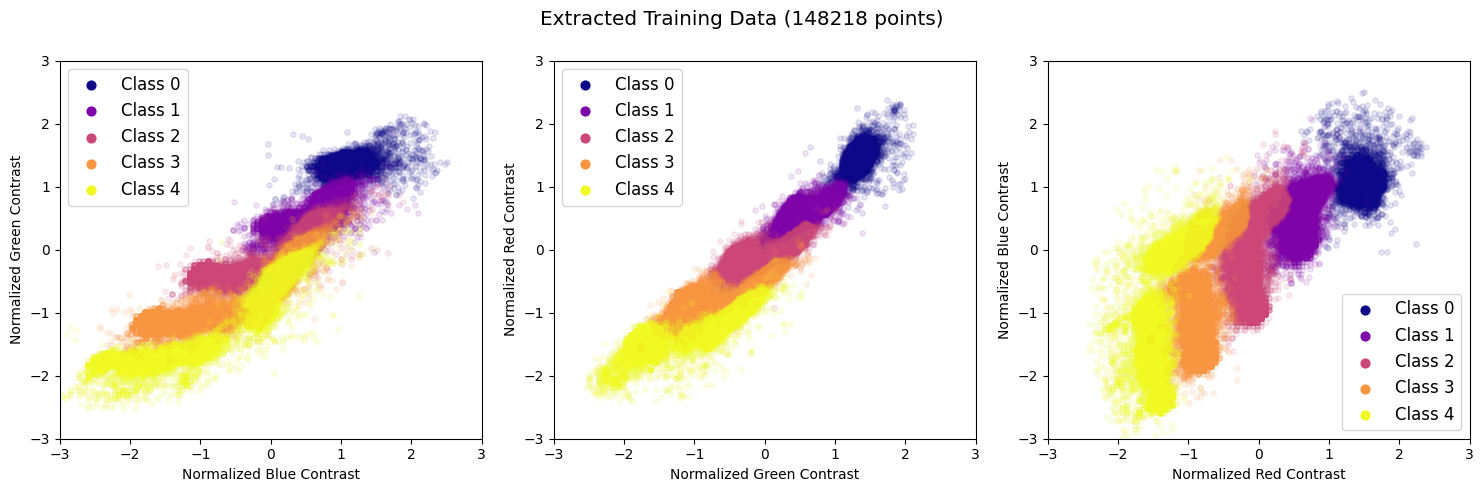

In [5]:
plot_data(dataloader.X_train, dataloader.y_train)

In [6]:
model = FCResNet(
    input_dim=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    depth=DEPTH,
    num_classes=NUM_CLASSES,
    spec_coeff=SPEC_COEFF,
    n_power_iterations=N_POWER_ITERATIONS,
    spectral_normalization=SPECTRAL_NORMALIZATION,
    dropout_rate=DROPOUT_RATE,
)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_function = LOSS_FUNCTION

In [7]:
best_test_loss, test_loss = np.inf, np.inf

for iteration in range(NUM_ITER):
    # set the model to training mode
    model.train()

    # request a new batch of data from the dataloader and convert it to torch tensors
    X_train, y_train = dataloader.get_batch(batch_size=BS)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.int64)

    # run a forward pass through the model
    logits = model(X_train)

    # compute the loss with the provided loss function
    loss = loss_function(logits, y_train)

    # run a backward pass to compute the gradients
    loss.backward()

    # update the model parameters
    optimizer.step()

    # zero the gradients for the next iteration
    optimizer.zero_grad()

    # evaluate the model on the test set if the test set is provided
    if iteration % TEST_INTERVAL == 0:
        train_loss = loss.item()

        if TEST_ANNOTATION_PATH is not None:
            model.eval()
            with torch.no_grad():
                logits = model(X_test)
                test_loss = loss_function(logits, y_test).item()
            if test_loss < best_test_loss:
                best_test_loss = test_loss

        print(
            f"Train Iteration: {iteration:8} Train Loss: {train_loss:10.5f} Test Loss: {test_loss:10.5f} Best test Loss: {best_test_loss:10.5f}",
            end="\r",
        )

# run a final evaluation on the test set if the test set is provided
if TEST_ANNOTATION_PATH is not None:
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        test_loss = loss_function(logits, y_test).item()
    if test_loss < best_test_loss:
        best_test_loss = test_loss

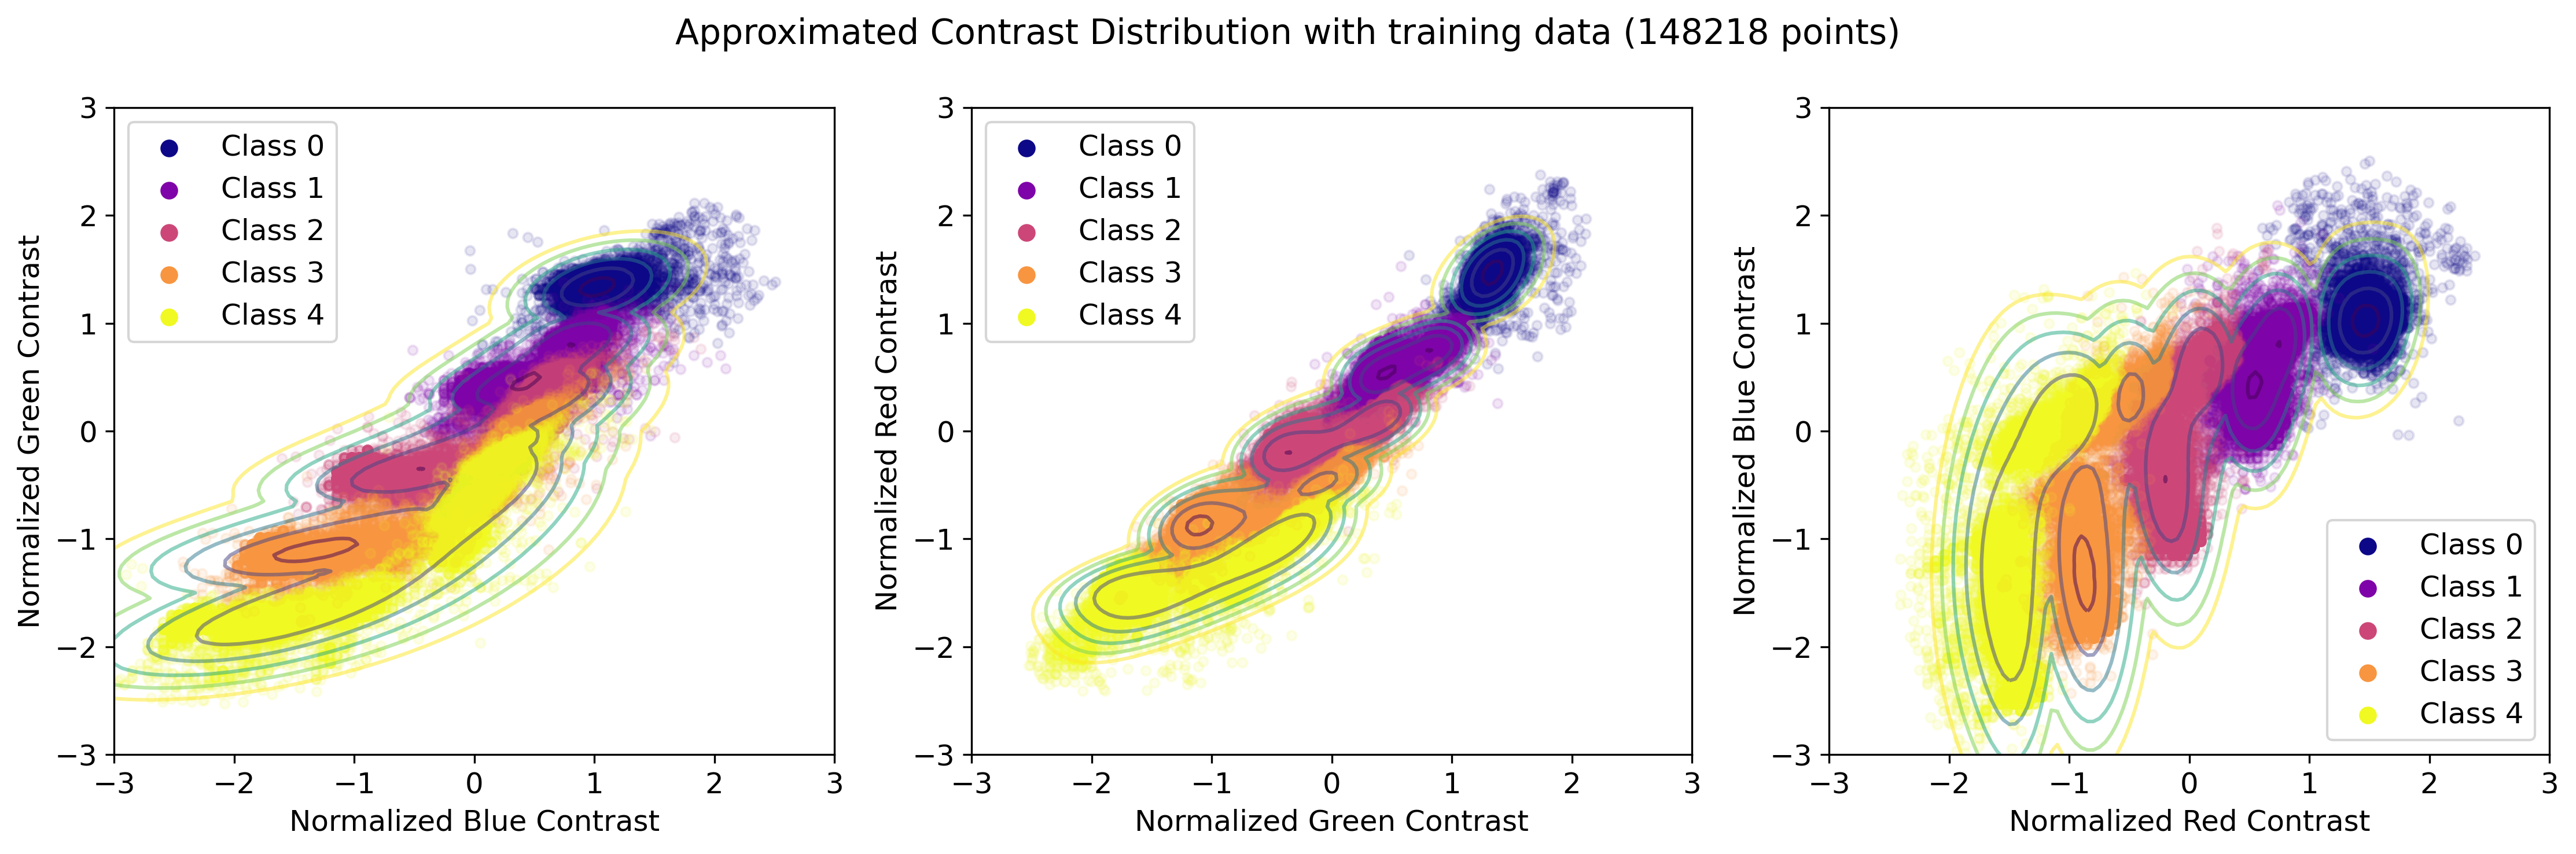

In [8]:
plot_distribution(model, dataloader.X_train, dataloader.y_train)

In [9]:
meta_data = {
    "train_config": {
        "train_params": {
            "num_iterations": NUM_ITER,
            "learning_rate": LR,
            "loss_function": str(LOSS_FUNCTION),
            "test_interval": TEST_INTERVAL,
            "batch_size": BS,
        },
        "data_params": {
            "max_samples_per_class": MAX_SAMPLES_PER_CLASS,
            "loaded_test_samples": LOADED_TEST_SAMPLES,
            "uniform_class_sampling": UNIFORM_CLASS_SAMPLING,
            "use_normalization": USE_NORMALIZATION,
            "use_DBSCAN": USE_DBSCAN,
            "DBSCAN_eps": DBSCAN_EPS,
            "use_Nearest_Neighbors": USE_NEAREST_NEIGHBORS,
            "neighbors": NEIGHBORS,
        },
        "model_arch": {
            "num_classes": NUM_CLASSES,
            "input_dim": INPUT_DIM,
            "embedding_dim": EMBEDDING_DIM,
            "depth": DEPTH,
            "spec_coeff": SPEC_COEFF,
            "n_power_iterations": N_POWER_ITERATIONS,
            "spectral_normalization": SPECTRAL_NORMALIZATION,
            "dropout_rate": DROPOUT_RATE,
        },
    },
    "test_losses": {
        "final": test_loss,
        "best": best_test_loss,
    },
    "train_mean": dataloader.X_train_mean.tolist(),
    "train_std": dataloader.X_train_std.tolist(),
    "train_image_dir": TRAIN_IMAGE_DIR,
    "train_annotation_path": TRAIN_ANNOTATION_PATH,
    "test_image_dir": TEST_IMAGE_DIR,
    "test_annotation_path": TEST_ANNOTATION_PATH,
}

In [ ]:
X_train_full = dataloader.X_train
y_train_full = dataloader.y_train

# set the model to evaluation mode and compute the embeddings for the training data
model.eval()
with torch.no_grad():
    X_torch = torch.tensor(X_train_full).float()
    X_cube_embeddings = model.get_embedding(X_torch)

# now we compute the mean and covariance of the embeddings for each class
# these should be distributed as a multivariate Gaussian
loc = torch.stack(
    [
        torch.mean(X_cube_embeddings[y_train_full == c], dim=0)
        for c in range(dataloader.num_classes)
    ]
)
# normally we would need to normalize the covariance matrix to avoid numerical issues
# but we save the unnormalized covariance matrix and normalize it later
cov = torch.stack(
    [
        torch.cov(X_cube_embeddings[y_train_full == c].T)
        for c in range(dataloader.num_classes)
    ]
)

# save the model, meta data, and the mean and covariance of the embeddings
os.makedirs(SAVE_DIR, exist_ok=True)
with open(os.path.join(SAVE_DIR, "meta_data.json"), "w") as f:
    json.dump(meta_data, f, indent=4)
np.save(os.path.join(SAVE_DIR, "loc.npy"), loc)
np.save(os.path.join(SAVE_DIR, "cov.npy"), cov)
torch.save(
    model.state_dict(),
    os.path.join(SAVE_DIR, "model.pth"),
)